## Setup pyspark

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=1a8a7b8a28dd2a28aca1211ffd9424a4d99ae57b17f5f465c3db237df8c089fd
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
!pip install findspark
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.10/dist-packages/pyspark'

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

## Import data

In [4]:
sc = SparkContext(appName="finicial fraud detection")
sqlc = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
## data
data_file = '/content/PS_20174392719_1491204439457_log.csv'

In [6]:
data = sqlc.read.csv(data_file,header = True)

## Data exploration

In [7]:
data.count()

233392

In [8]:
data.dtypes

[('step', 'string'),
 ('type', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('isFraud', 'string'),
 ('isFlaggedFraud', 'string')]

To retrieve the first 3 rows of the DataFrame data in PySpark and convert them to a Pandas DataFrame for better understanding.

In [9]:
data.limit(3).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0


To group the DataFrame data by the 'isFraud' column and count the number of occurrences for each group in PySpark


In [10]:
data.groupBy('isFraud').count().show()

+-------+------+
|isFraud| count|
+-------+------+
|      0|233235|
|      1|   157|
+-------+------+



In [11]:
#Check if there is missing values in the data
from pyspark.sql.functions import col,sum
data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in data.columns)).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### Understand the data which belongs to fraudulent

In [12]:
subd = data.filter(data['isFraud'] == 1).groupby('type').count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER|   77|
|CASH_OUT|   80|
+--------+-----+



**Observation**: it looks only type is TRANSFER or CASH_OUT will be fraud.

In [13]:
data.groupby('isFlaggedFraud').count().show()

+--------------+------+
|isFlaggedFraud| count|
+--------------+------+
|             0|233392|
+--------------+------+



In [14]:
df1 = data.filter(data['isFraud'] == 1) ## fraud
df0 = data.filter(data['isFraud'] == 0) ## not fraud

In the above, df1 is the data which has 1 in isFraud column and df2 is the data which has 0 in isFraud column

## Data cleaning

In [15]:
x0 = data.filter(data['type'].isin(['CASH_OUT','TRANSFER']))

Filters the DataFrame data to include only the rows where the value in the 'type' column is either 'CASH_OUT' or 'TRANSFER'. This is done to focus on specific transaction types relevant to fraud detection.

##### Destination account - replace zero with -1

In [16]:
### chang 0 to more sensible values for some cases
from pyspark.sql.functions import when
import numpy as np

x0 = x0.withColumn('oldbalanceDest', \
              when((x0['oldbalanceDest'] == 0) & (x0['newbalanceDest'] ==0) & (x0['amount'] !=0), -1).otherwise(x0['oldbalanceDest']))

x0 = x0.withColumn('newbalanceDest', \
              when((x0['oldbalanceDest'] == 0) & (x0['newbalanceDest'] ==0) & (x0['amount'] !=0), -1).otherwise(x0['newbalanceDest']))

It replaces the zero values in the 'oldbalanceDest' and 'newbalanceDest' columns with -1 in cases where the conditions (oldbalanceDest == 0), (newbalanceDest == 0), and (amount != 0) are met. This replacement is performed to assign more meaningful values for certain cases.

#### Convert string to numeric columns

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(x0) for column in ['type'] ]


pipeline = Pipeline(stages=indexers)
x_r = pipeline.fit(x0).transform(x0)

It converts the 'type' column from a string type to a numeric type using the StringIndexer transformer. This is necessary because machine learning algorithm which we have used work with numeric data rather than strings.

In [18]:
x_r.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_index
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1.0
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0.0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0.0
3,1,TRANSFER,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1.0
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1.0


In [19]:
from pyspark.sql.types import IntegerType

In [20]:
xx = x_r.withColumn('type_index',x_r['type_index'].cast(IntegerType()))
xx = xx.withColumn('isFraud',x_r['isFraud'].cast(IntegerType()))
xx = xx.withColumnRenamed('isFraud','label')

 Converts the data types of the 'type_index' and 'isFraud' columns to IntegerType, which is the appropriate data type for labels. It also renames the 'isFraud' column to 'label' to conform to common naming conventions in machine learning.

In [21]:
xx.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0
3,1,TRANSFER,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


In [22]:
xf = xx.drop('type')

It removes the 'type' column from the DataFrame xx as it has been transformed into the 'type_index' column.

In [23]:
xf.limit(5).toPandas()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index
0,1,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1
1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0
3,1,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


## Feature enginering

In [24]:
xf = xf.withColumn("errorbalanceOrig", col("newbalanceOrig") + col("amount") - col("oldbalanceOrg"))

In [25]:
xf = xf.withColumn("errorbalanceDest", col("oldbalanceDest") + col("amount") - col("newbalanceDest"))

It adds two new columns, 'errorbalanceOrig' and 'errorbalanceDest', to the DataFrame xf. These columns are computed based on existing columns and represent the error or deviation in the balance values for the original and destination accounts.

In [26]:
xf.limit(5).toPandas()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index,errorbalanceOrig,errorbalanceDest
0,1,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1,0.00,180.0
1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0,0.00,21363.0
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0,213808.94,182703.5
3,1,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1,214605.30,237735.3
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,300850.89,-2401220.0


## convert data frame types

In [27]:
xf.dtypes

[('step', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

In [28]:
sxv = ['step',
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest']
for col_name in sxv:
    xf = xf.withColumn(col_name, col(col_name).cast('float'))

It converts the data types of selected columns (step, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest) to FloatType. This step ensures that the numerical columns have the appropriate data type for further processing.

In [29]:
xf.dtypes

[('step', 'float'),
 ('amount', 'float'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'float'),
 ('newbalanceOrig', 'float'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'float'),
 ('newbalanceDest', 'float'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

## Train and test data split

In [30]:
from pyspark.sql.functions import lit

In [31]:
fractions = xf.select("label").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
df_train = xf.sampleBy('label',fractions,seed=17)
df_test = xf.subtract(df_train)

### create a SVC classifer

In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Create a VectorAssembler to assemble the feature columns into a single "features" column
assembler = VectorAssembler(inputCols=['step', 'type_index', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorbalanceOrig', 'errorbalanceDest'],
                            outputCol='features')

# Apply the VectorAssembler to the training data
df_train = assembler.transform(df_train)

# Create a LinearSVC model
svm = LinearSVC(labelCol="label", featuresCol="features", regParam=0.0)

# Create a parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.0, 0.1, 1.0]) \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .build()

# Create an evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")

# Create TrainValidationSplit for tuning
tvs = TrainValidationSplit(estimator=svm,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Fit the model and perform tuning
model = tvs.fit(df_train)

# Apply the VectorAssembler to the test data
df_test = assembler.transform(df_test)

# Make predictions on the test data
predictions = model.transform(df_test)

# Evaluate the accuracy of the predictions
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy * 100)


Accuracy: 93.76127685199252


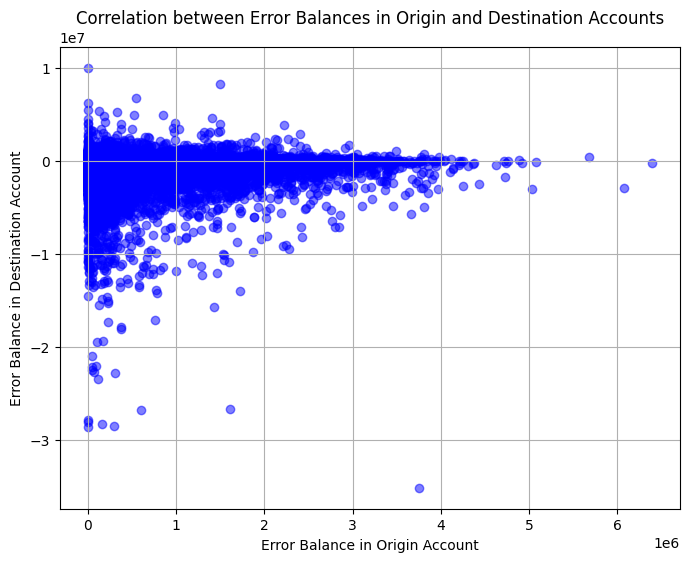

In [34]:
# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
xf_pd = xf.select('errorbalanceOrig', 'errorbalanceDest').toPandas()

# Scatter plot of 'errorbalanceOrig' vs. 'errorbalanceDest'
plt.figure(figsize=(8, 6))
plt.scatter(xf_pd['errorbalanceOrig'], xf_pd['errorbalanceDest'], alpha=0.5, c='blue')
plt.xlabel('Error Balance in Origin Account')
plt.ylabel('Error Balance in Destination Account')
plt.title('Correlation between Error Balances in Origin and Destination Accounts')
plt.grid(True)
plt.show()


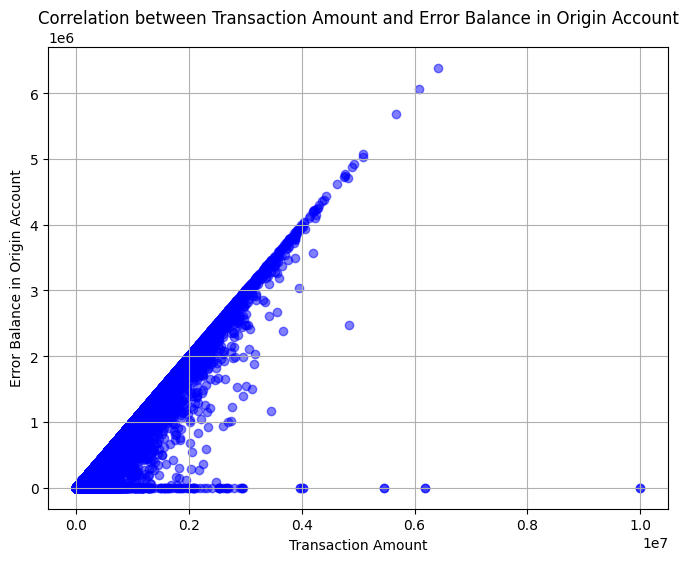

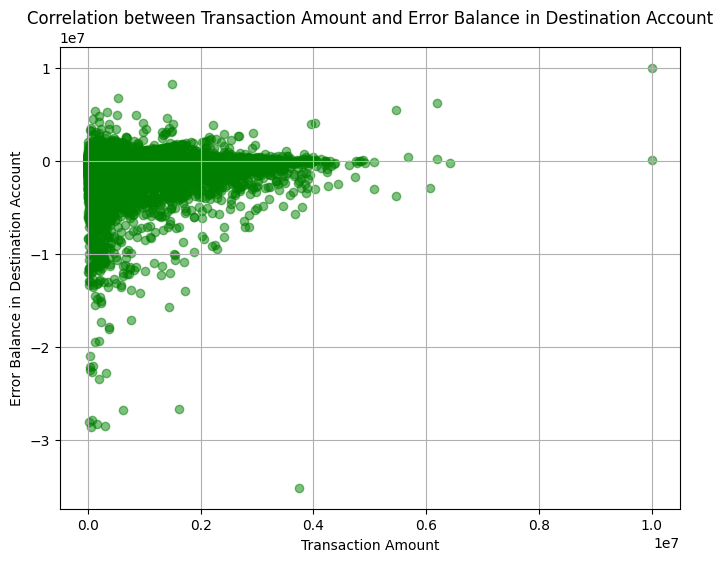

In [41]:
from pyspark.sql.types import FloatType

xf = xf.withColumn('amount', xf['amount'].cast(FloatType()))

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
df1_balances_pd = df1.select('oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest').toPandas()

# Box plot for origin and destination account balances for fraud transactions
plt.figure(figsize=(12, 6))
plt.boxplot([df1_balances_pd['oldbalanceOrg'], df1_balances_pd['newbalanceOrig'], df1_balances_pd['oldbalanceDest'], df1_balances_pd['newbalanceDest']],
            labels=['Old Balance in Origin', 'New Balance in Origin', 'Old Balance in Destination', 'New Balance in Destination'])
plt.xlabel('Account Balances')
plt.ylabel('Amount')
plt.title('Balance Distribution in Origin and Destination Accounts for Fraud Transactions')
plt.grid(True)
plt.show()
